In [17]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numpy.random import seed
from sklearn import datasets
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn.pipeline import Pipeline
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import accuracy_score,confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import combinations

### Loading Breast Cancer dataset

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()
print('The dimensions of the cancer dataset is %d x %d'%(len(df.iloc[:,1]),len(df.iloc[0,:])))

The dimensions of the cancer dataset is 569 x 32


In [3]:
# Extract the features and labels
X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

print('The dimensions of the data is %d x %d'%(X.shape[0],X.shape[1]))
print('The dimensions of the labels is %d '%(len(y)))

The dimensions of the data is 569 x 30
The dimensions of the labels is 569 


In [4]:
# Split the data into train and test
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

print('The dimensions of the training data is %d x %d'%(X_train.shape[0],X_train.shape[1]))
print('The dimensions of the training labels is %d '%(len(y_train)))
print('The dimensions of the test data is %d x %d'%(X_test.shape[0],X_test.shape[1]))
print('The dimensions of the test labels is %d '%(len(y_test)))

The dimensions of the training data is 455 x 30
The dimensions of the training labels is 455 
The dimensions of the test data is 114 x 30
The dimensions of the test labels is 114 


In [5]:
# Using pipeline to perform standardization, PCA and Logistic regression


pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca',PCA(n_components=2)),
                    ('clf',LogisticRegression(random_state=1))])
pipe_lr.fit(X_train,y_train)

print('Test accuracy is %.3f'%(pipe_lr.score(X_test,y_test)))

Test accuracy is 0.947


### K-Fold Cross Validation

In [6]:
scores = cross_val_score(estimator=pipe_lr, 
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)

print('CV Accuracy scores: ',scores)

print('Average score with standard deviation: %.3f +- %.3f'%(np.mean(scores),np.std(scores)))

CV Accuracy scores:  [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
Average score with standard deviation: 0.950 +- 0.029


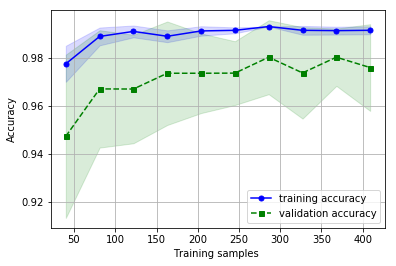

In [7]:
# Learning curves


pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('clf',LogisticRegression(random_state=1))])


train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr,
                                                      X=X_train,
                                                      y=y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10),
                                                      cv=10,
                                                      n_jobs=1)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean, color='blue',
         marker='o',markersize=5,label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color='blue')


plt.plot(train_sizes,test_mean, color='green', linestyle='--',
         marker='s',markersize=5,label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color='green')

plt.grid()
plt.xlabel('Training samples ')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()




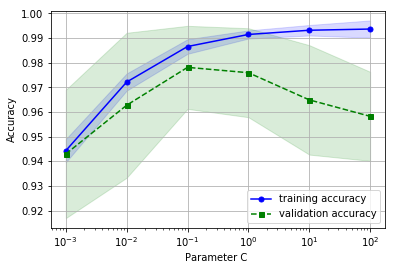

In [8]:
# Validation curves


pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('clf',LogisticRegression(random_state=1))])

param_range = [0.001,0.01,0.1,1.0,10.0,100.0]

train_scores,test_scores = validation_curve(estimator=pipe_lr,
                                                      X=X_train,
                                                      y=y_train,
                                                      param_name = 'clf__C',
                                                      param_range=param_range,
                                                      cv=10)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(param_range,train_mean, color='blue',
         marker='o',markersize=5,label='training accuracy')

plt.fill_between(param_range, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color='blue')


plt.plot(param_range,test_mean, color='green', linestyle='--',
         marker='s',markersize=5,label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C ')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Grid Search

In [9]:

pipe_svc = Pipeline([('scl',StandardScaler()),
                    ('clf',SVC(random_state=1))])

param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

param_grid = [  {'clf__C':param_range,
                 'clf__kernel':['linear']},
                {'clf__C':param_range,
                 'clf__gamma':param_range,
                 'clf__kernel':['rbf']}]


gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)


clf = gs.best_estimator_
clf.fit(X_train,y_train)
print('Test Accuracy is %.3f'%(clf.score(X_test,y_test)))

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Test Accuracy is 0.965


In [10]:
# Nested cross validation

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)


scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)

print('Average score with standard deviation: %.3f +- %.3f'%(np.mean(scores),np.std(scores)))

Average score with standard deviation: 0.965 +- 0.025


### Evaluation Metrics



In [11]:
# Confusion Matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_test,y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [12]:
# Precision, Recall and F1-score
print('Precision: %0.3f'%(precision_score(y_test,y_pred)))
print('Recall: %0.3f'%(recall_score(y_test,y_pred)))
print('F1-score: %0.3f'%(f1_score(y_test,y_pred)))



Precision: 0.976
Recall: 0.952
F1-score: 0.964


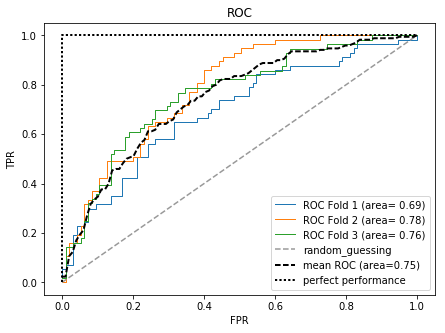

In [19]:
# ROC and AUC


pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca',PCA(n_components=2)),
                    ('clf',LogisticRegression(random_state=0,C=100.0))])

X_train2 = X_train[:,[4,14]]

cv = StratifiedKFold(y_train,
                     n_folds = 3,
                     random_state=1)

fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_trp = []

for i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    
    fpr,tpr,thresholds = roc_curve(y_train[test], probas[:,1],pos_label=1)
    
    mean_tpr += interp(mean_fpr,fpr,tpr)
    
    roc_auc = auc(fpr,tpr)
    
    plt.plot(fpr,tpr, lw=1, label='ROC Fold %d (area= %0.2f)'%(i+1, roc_auc))
    
    
    
plt.plot([0,1],[0,1], linestyle='--', color=(0.6,0.6,0.6), label='random_guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label = 'mean ROC (area=%0.2f)'% mean_auc,lw=2)
plt.plot([0,0,1],[0,1,1], lw=2,linestyle=':', color='black', label='perfect performance')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.title('ROC')
plt.show()

